In [1]:
from matplotlib.pyplot import imread

# -*- coding: utf-8 -*-
"""
Created on Saturday Nov 15 15:34 2025

@author: 100yearsahead


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


path = "../coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

# Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
# df.drop("Date_Year", axis=1, inplace=True)
# df.drop("Bleaching_Level", axis=1, inplace=True)
# df.drop("Realm_Name", axis=1, inplace=True)
# # #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # # For the sake of bigger dataset this feature is dropped
# df.drop("Percent_Cover", axis=1, inplace=True)
# # df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# # df.drop("Temperature_Maximum", inplace=True, axis=1)

# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
# df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
#df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

df  = df.drop(columns=['Sample_ID'])
df.dropna(inplace=True)

df.info()
print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 22561 entries, 6981 to 35042
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    22561 non-null  float64
 1   Depth_m              22561 non-null  float64
 2   ClimSST              22561 non-null  float64
 3   Ocean_Name           22561 non-null  object 
 4   Country_Name         22561 non-null  object 
 5   Distance_to_Shore    22561 non-null  float64
 6   Exposure             22561 non-null  object 
 7   Turbidity            22561 non-null  float64
 8   Date_Year            22561 non-null  int64  
 9   Bleaching_Level      22561 non-null  object 
 10  Temperature_Maximum  22561 non-null  float64
 11  SSTA                 22561 non-null  float64
 12  TSA                  22561 non-null  float64
 13  Percent_Bleaching    22561 non-null  float64
 14  Temperature_Mean     22561 non-null  float64
 15  Realm_Name           22561 non-null  o

In [2]:
features_to_drop =['SSTA', 'TSA', 'Temperature_Mean', 'Temperature_Maximum', 'Exposure', 'Percent_Cover', 'Turbidity', ]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

df_edit = df.drop(columns=features_to_drop, axis=1)

# Split first (no leakage)
X = df_edit.drop(columns=['Percent_Bleaching'])
y = df_edit['Percent_Bleaching']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Since we have categorical variables we need to seperate the numeric and the categorical variables
cat_cols = ['Ocean_Name', 'Country_Name', 'Realm_Name', 'Bleaching_Level']
num_cols = [col for col in X.columns if col not in cat_cols]



# We one_hot_encode the categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])


# We scale the numeric features
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])


# Combine the categorical and numerical features
X_train_processed = np.hstack([X_train[num_cols], X_train_cat])
X_test_processed  = np.hstack([X_test[num_cols], X_test_cat])

In [4]:
import xgboost as xgb

params = {
    'colsample_bytree': 1.0,
    'device': 'cuda',
    'gamma': 0.3,
    'learning_rate': 0.1,
    'max_depth': 12,
    'min_child_weight': 6,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'subsample': 0.7,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',  # For regression task
    'eval_metric': 'mae',
}



xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, #we dont need to add penalty since there`s enough samples I guess
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)

xgb_model.fit(X_train_processed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

0.8733125283190425
0.8725603223232993


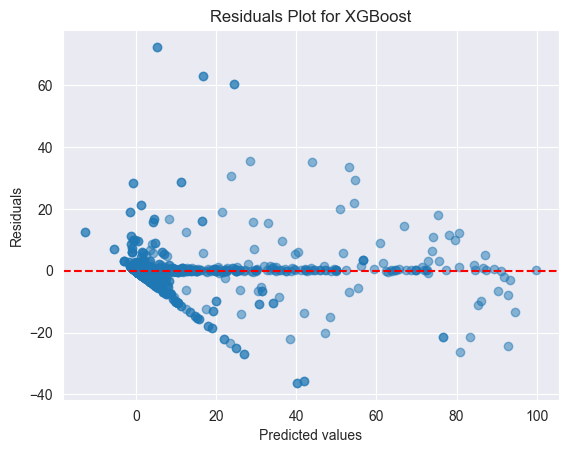

In [357]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred = xgb_model.predict(X_test_processed)

score = r2_score(y_test, y_pred)

print(score)
# print(model.oob_score_)
print(mean_absolute_error(y_test, y_pred))

residuals = y_test - y_pred

# Plot residuals vs predicted
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for XGBoost")
plt.show()

With 32K samples

0.7242873609687253
3.7487208215175865

With 22K Samples

0.8695503922086502
0.8771978434149127


In [323]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

model.fit(X_train_processed, y_train)

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

0.8736950712082585
0.72326559944744


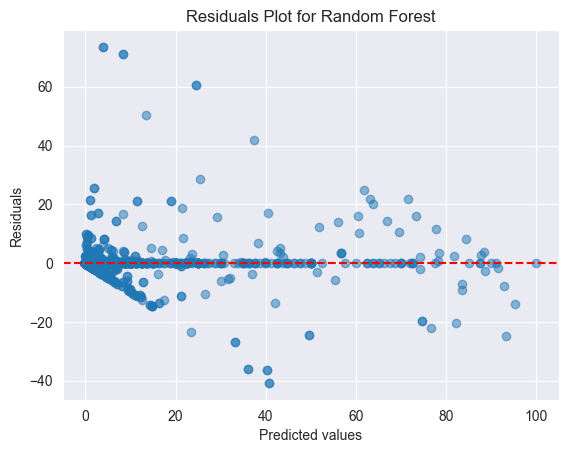

In [335]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred = model.predict(X_test_processed)

score = r2_score(y_test, y_pred)

print(score)
# print(model.oob_score_)
print(mean_absolute_error(y_test, y_pred))

residuals = y_test - y_pred

# Plot residuals vs predicted
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Random Forest")
plt.show()


With 32K Samples
0.7466782215018972
3.195973918510298

With 22K Samples
0.8761453854236719
0.7263877535132548


The good performance of the Random Forest model on high-dimensional feature sets can be attributed to its ensemble nature and its ability to aggregate a large number of weak but diverse predictors.

In contrast, XGBoost rely on sequential learning, where each new tree attempts to correct the residual errors of the previous ones. When the dataset contains only a few strong predictors, XGBoost can explore these features more deeply and model complex interactions.

After Feature engeneering XGBoost has improved its accuracy by 7%, while RF only 5


For example by cutting Realm_Name XGB performance increased by 2% and RF by 5%. However, ClimSST increased XGB by 1% but decreased RF by 0.5%. Cyclone_Frequency did no affected RF, but decreased XGB by 3%. Categorical data significantly affects RF training time . More categories - longer training

In [310]:
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for i, v in zip(X.columns ,importance):
    print(f'Feature: {i}, Score: {v:.5f}')


threshold = 0.03
selected_features = [
    f for f, s in zip(X.columns, importance)
    if s < threshold
]

selected_features

Feature: Cyclone_Frequency, Score: 0.06086
Feature: Depth_m, Score: 0.05867
Feature: ClimSST, Score: 0.07932
Feature: Ocean_Name, Score: 0.05374
Feature: Country_Name, Score: 0.03490
Feature: Distance_to_Shore, Score: 0.09135
Feature: Exposure, Score: 0.03936
Feature: Turbidity, Score: 0.07023
Feature: Date_Year, Score: 0.09695
Feature: Bleaching_Level, Score: 0.05183
Feature: Temperature_Maximum, Score: 0.02611
Feature: SSTA, Score: 0.00007
Feature: TSA, Score: 0.00407
Feature: Temperature_Mean, Score: 0.00826
Feature: Realm_Name, Score: 0.00887
Feature: Percent_Cover, Score: 0.00003


['Temperature_Maximum',
 'SSTA',
 'TSA',
 'Temperature_Mean',
 'Realm_Name',
 'Percent_Cover']

After selecting features to drop trees been revalued and some features loses its important so its better to run importance selection several time until it stops performing

In [9]:
xgb.to_graphviz(xgb_model, tree_index=2)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH